In [29]:
#importing some useful packages

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob
import numpy as n
import cv2
import os

opj = os.path.join

%matplotlib inline

## Code below serves as full pipeline for advanced lane finding

## Read in an image

This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


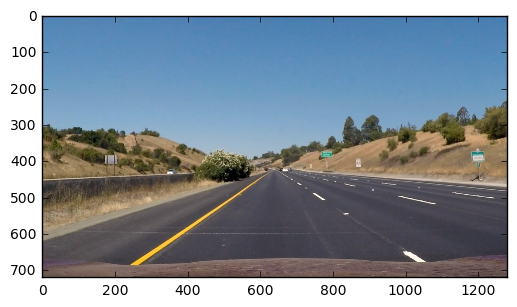

In [30]:
#reading in an image
image = mpimg.imread('test_images/straight_lines1.jpg')

#printing out some stats and plotting
print('This image is:', type(image), 'with dimensions:', image.shape)
plt.imshow(image)

## Camera Calibration

In [31]:
def calibrate_camera(cam_cali_dir, num_corners=(9,6)):

    # to store object and image objects
    objpoints = []
    imgpoints = []

    # object points if possible
    num_obj_w = num_corners[0]
    num_obj_h = num_corners[1]
    objp = n.zeros((num_obj_w*num_obj_h, 3), n.float32)
    objp[:,:2] = n.mgrid[0:num_obj_w,0:num_obj_h].T.reshape(-1,2) # x, y coordinates

    for fname in os.listdir(cam_cali_dir):
        img = mpimg.imread(opj(cam_cali_dir, fname))

        # convert to grayscale
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

        # find corners on the chessboard
        ret, corners = cv2.findChessboardCorners(gray, (num_obj_w, num_obj_h), None)

        # if corners found, add object points and image points
        if ret == True:
            imgpoints.append(corners)
            objpoints.append(objp)

            # draw and display the corners
            img = cv2.drawChessboardCorners(img, (num_obj_w, num_obj_h), corners, ret)
    return objpoints, imgpoints

In [32]:
cam_cali_dir = 'camera_cal/'
objpoints, imgpoints = calibrate_camera(cam_cali_dir, num_corners=(9,6))

## Correct for distortion

In [33]:
def cal_undistort(img, objpoints, imgpoints):
    # Use cv2.calibrateCamera() and cv2.undistort()
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    return undist

In [34]:
undist_image = cal_undistort(image, objpoints=objpoints, imgpoints=imgpoints)

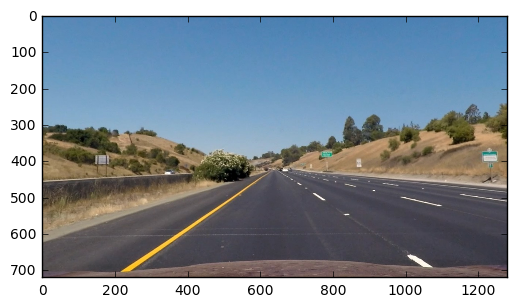

In [35]:
plt.imshow(undist_image)

## Color and Gradient threshold

In [36]:
def abs_sobel_thresh(img, orient='x', sobel_kernel=3, thresh=(0, 255)):
    # Calculate directional gradient
    # Apply threshold
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    if orient == 'x':
        abs_sobel = n.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0))
    if orient == 'y':
        abs_sobel = n.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1))
    scaled_sobel = n.uint8(255*abs_sobel/n.max(abs_sobel))
    grad_binary = n.zeros_like(scaled_sobel)
    grad_binary[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1
    return grad_binary

def mag_thresh(img, sobel_kernel=3, mag_thresh=(0, 255)):
    # Calculate gradient magnitude
    # Apply threshold
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Take both Sobel x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Calculate the gradient magnitude
    gradmag = n.sqrt(sobelx**2 + sobely**2)
    # Rescale to 8 bit
    scale_factor = n.max(gradmag)/255 
    gradmag = (gradmag/scale_factor).astype(n.uint8) 
    # Create a binary image of ones where threshold is met, zeros otherwise
    mag_binary = n.zeros_like(gradmag)
    mag_binary[(gradmag >= mag_thresh[0]) & (gradmag <= mag_thresh[1])] = 1
    return mag_binary

def dir_threshold(img, sobel_kernel=3, thresh=(0, n.pi/2)):
    # Calculate gradient direction
    # Apply threshold
    # Grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Calculate the x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Take the absolute value of the gradient direction, 
    # apply a threshold, and create a binary image result
    absgraddir = n.arctan2(n.absolute(sobely), n.absolute(sobelx))
    dir_binary =  n.zeros_like(absgraddir)
    dir_binary[(absgraddir >= thresh[0]) & (absgraddir <= thresh[1])] = 1
    return dir_binary

def hls_select(img, thresh=(0, 255)):
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    s_channel = hls[:,:,2]
    binary_output = n.zeros_like(s_channel)
    binary_output[(s_channel > thresh[0]) & (s_channel <= thresh[1])] = 1
    return binary_output

def grad_threshold(img, ksize=11, do_plot=True):
    # Choose a Sobel kernel size

    # Apply each of the thresholding functions
    gradx = abs_sobel_thresh(img, orient='x', sobel_kernel=ksize, thresh=(30, 255))
    grady = abs_sobel_thresh(img, orient='y', sobel_kernel=ksize, thresh=(30, 255))
    mag_binary = mag_thresh(img, sobel_kernel=ksize, mag_thresh=(30, 255))
    dir_binary = dir_threshold(img, sobel_kernel=ksize, thresh=(n.pi/6, n.pi/3))
    s_binary = hls_select(img, thresh=(170, 255))
    
    # did NOT use gradient directions
    grad_img = s_binary | gradx
    
    if do_plot:
        fig = plt.figure()
        ax = fig.add_subplot(111)
        ax.imshow(img, cmap='gray')
        ax.set_title('before gradient thresholding')
        fig = plt.figure()
        ax = fig.add_subplot(111)
        ax.imshow(grad_img, cmap='gray')
        ax.set_title('after gradient thresholding')
        plt.show()
    return grad_img

def crop_roi(img, vertices, do_plot=True):
    ignore_mask_color = 255
    mask = n.zeros_like(img)
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    masked = cv2.bitwise_and(img, mask)
    if do_plot:
        fig = plt.figure()
        ax = fig.add_subplot(111)
        ax.imshow(masked, cmap='gray')
        ax.set_title('after masking ROI')
        plt.show()
    return masked

def masked_grad_image(images, do_plot=True):
    masked_grad_images = []
    for image in images:
        grad_image = grad_threshold(image, do_plot=do_plot)
        h, w = grad_image.shape[:2]
        h_offset = 50

        # get ROI
        lower_left = (100, h - h_offset)
        upper_left = (550, 420)
        upper_right = (666, 420)
        lower_right = (1200, h - h_offset)
        vertices = n.array([[lower_left, upper_left, upper_right, lower_right]], dtype=n.int32)

        # crop ROI
        masked_grad_image = crop_roi(grad_image, vertices, do_plot=do_plot)
        masked_grad_images.append(masked_grad_image)
    return masked_grad_images

In [37]:
images = []
for fname in os.listdir('test_images/'):
    image = mpimg.imread(opj('test_images/', fname))
    undist_image = cal_undistort(image, objpoints=objpoints, imgpoints=imgpoints)
    images.append(undist_image)

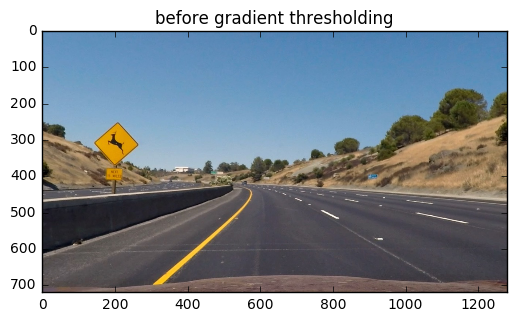

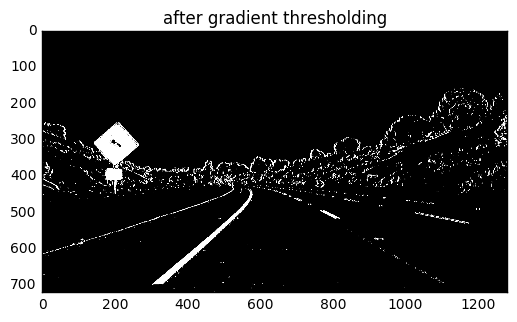

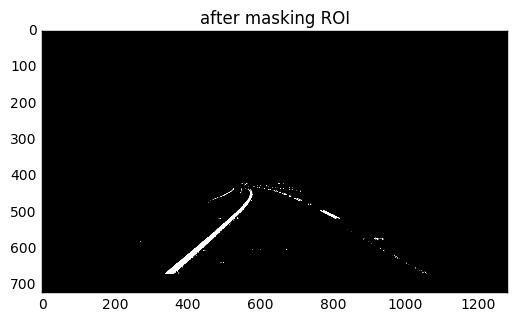

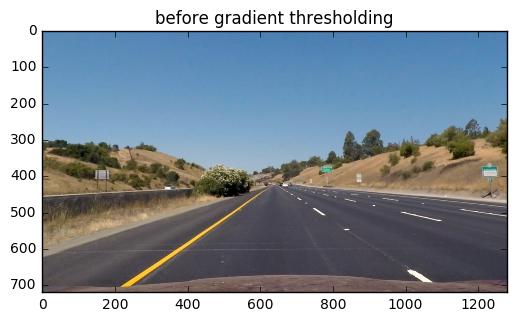

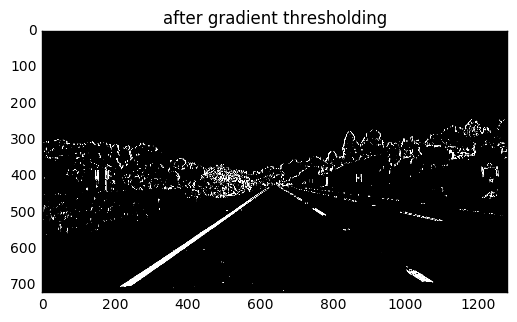

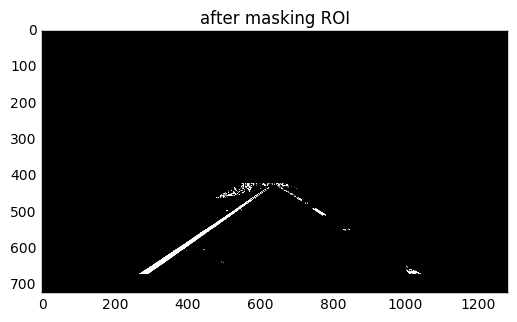

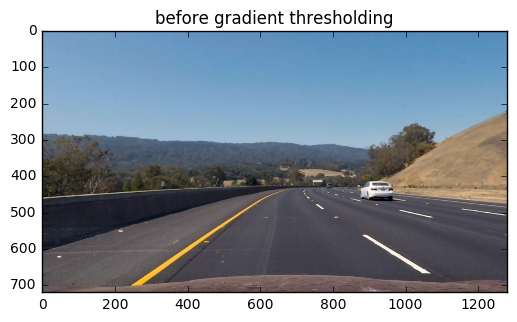

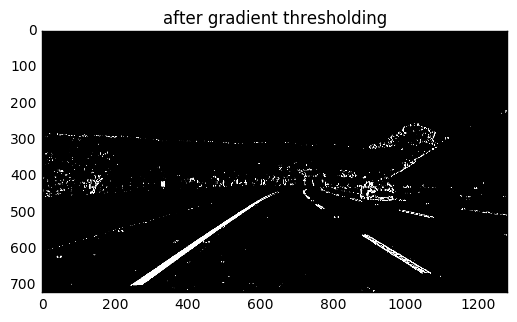

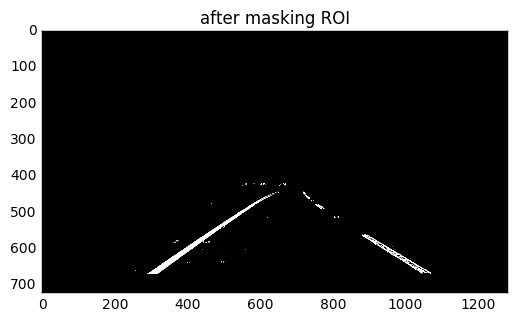

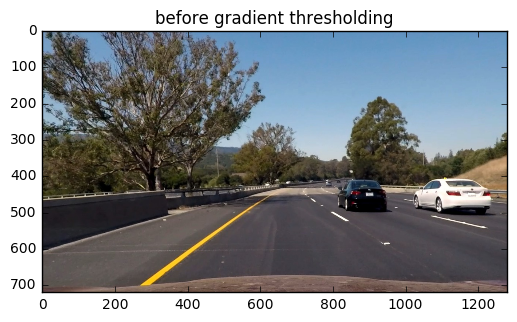

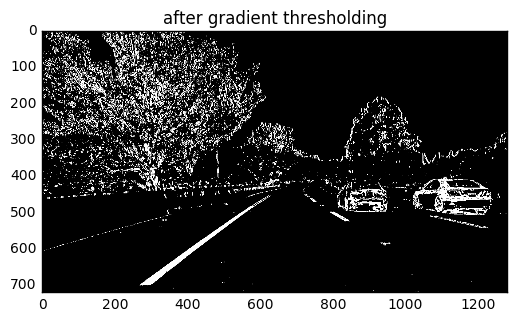

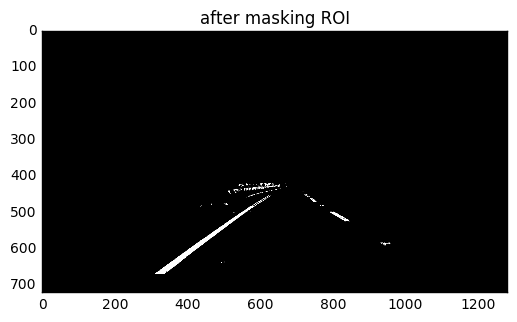

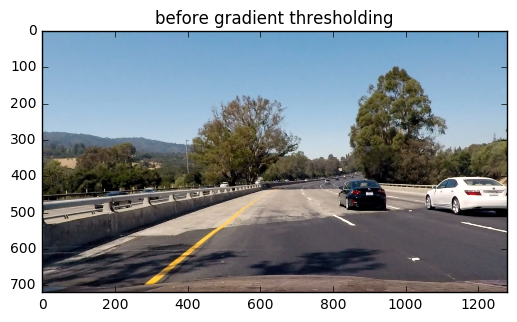

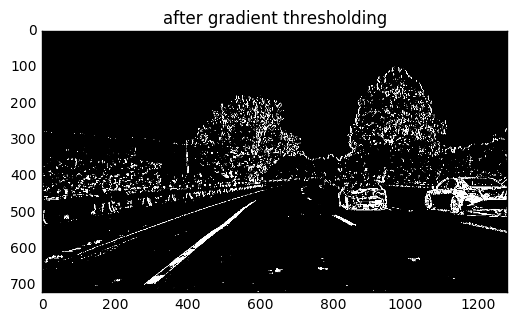

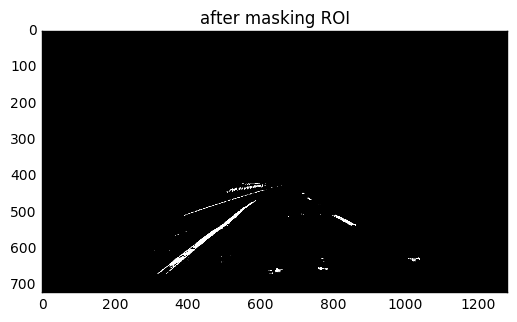

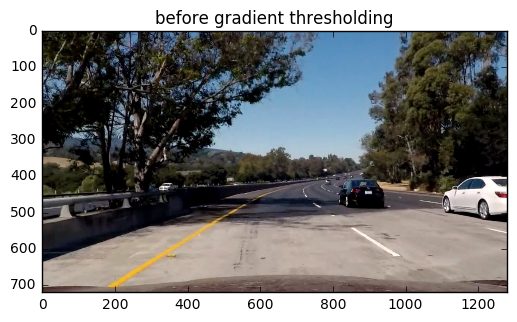

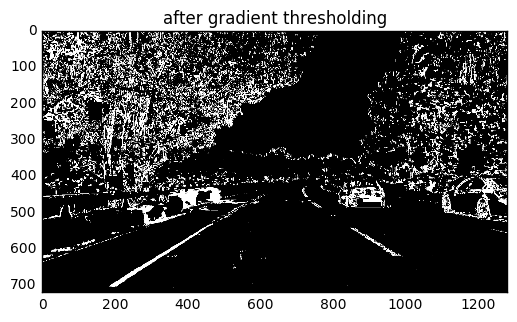

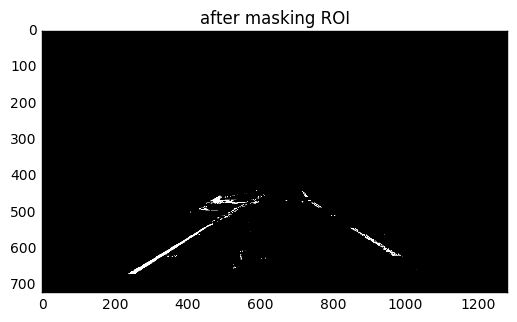

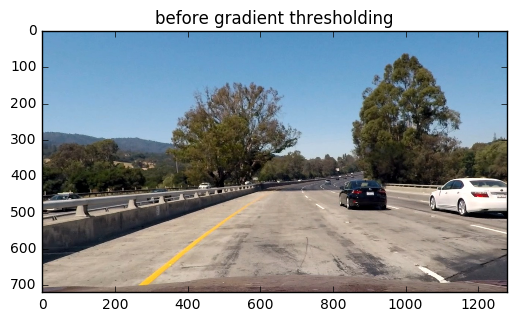

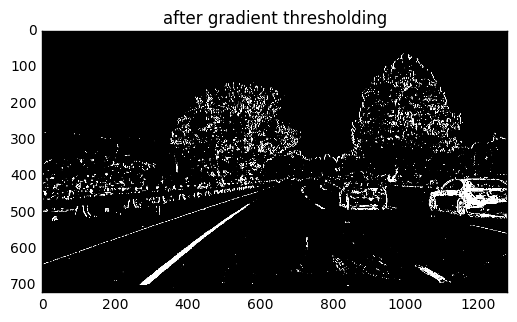

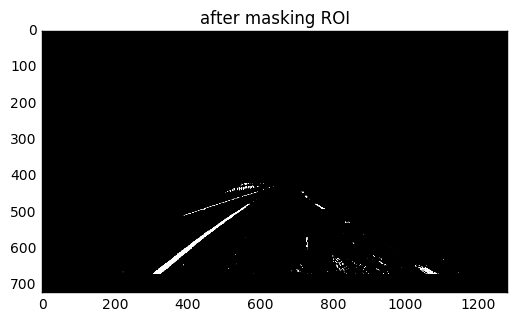

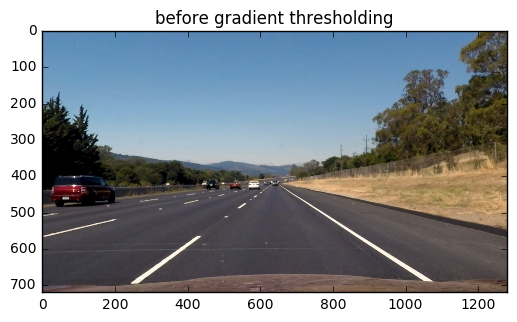

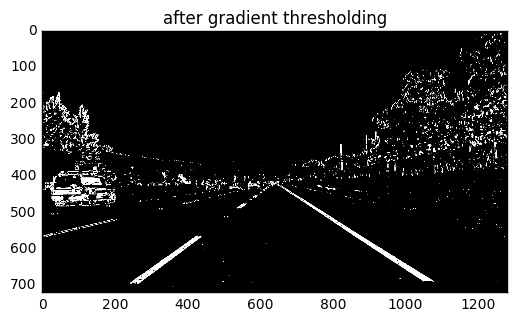

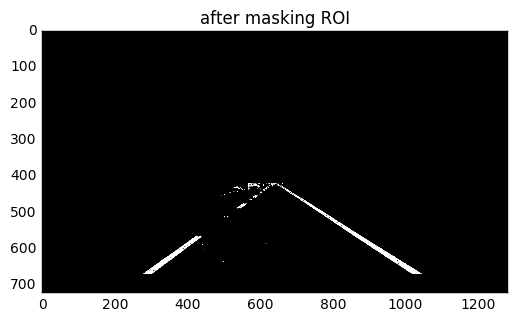

In [38]:
masked_grad_images = masked_grad_image(images, do_plot=True)

## Apply perspective transform

In [41]:
def apply_perspective_transform(undist, src, dst, do_plot=True, cmap='gray', return_M=True):
    img_size = undist.shape[1], undist.shape[0]
    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)
    warped = cv2.warpPerspective(undist, M, img_size, flags=cv2.INTER_LINEAR)
    if do_plot:
        undist_cp = undist.copy()
        warped_cp = warped.copy()
        fig = plt.figure()
        ax = fig.add_subplot(111)
        cv2.polylines(undist_cp,n.int32([src]),True,(0,255,255),10)
        ax.imshow(undist_cp, cmap=cmap)
        ax.set_title('img before perspective transform')
        fig = plt.figure()
        ax = fig.add_subplot(111)
        cv2.polylines(warped_cp,n.int32([dst]),True,(0,255,255),10)
        ax.imshow(warped_cp, cmap=cmap)
        ax.set_title('img after perspective transform')
    if return_M:
        return warped, M, Minv
    else:
        return warped

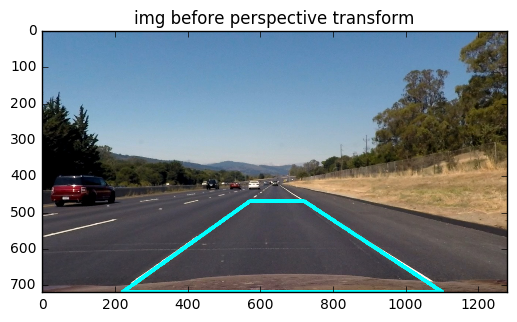

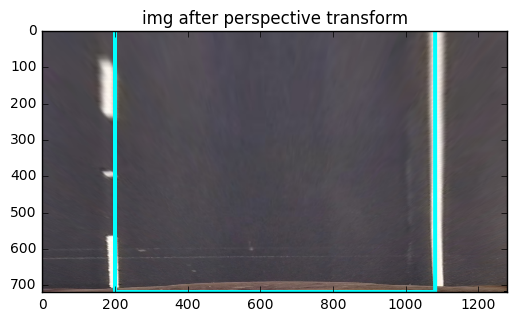

In [42]:
src = n.array([[220, 720], [570, 470], [720, 470], [1100, 720]], dtype=n.float32)
dst = n.array([[200,720], [200,0], [1080,0], [1080,720]], dtype=n.float32)
warped = apply_perspective_transform(undist_image, src, dst, do_plot=True)

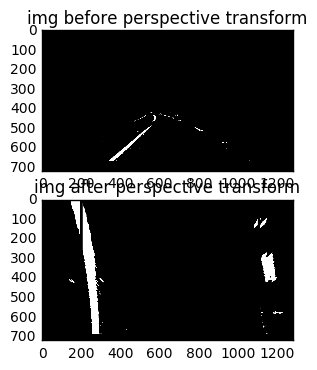

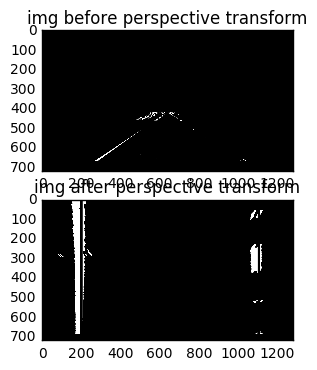

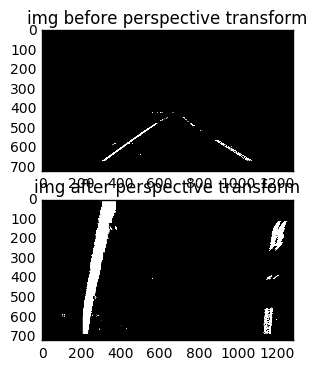

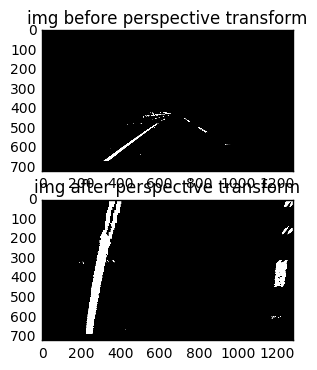

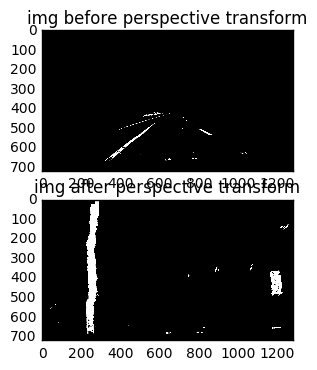

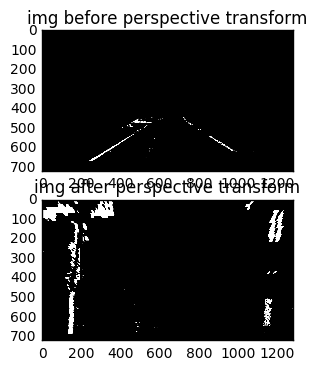

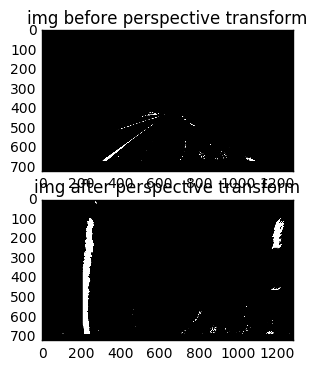

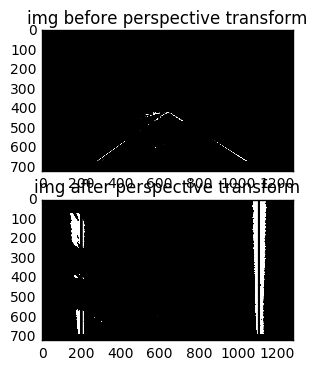

In [12]:
images = []
src = n.array([[220, 720], [570, 470], [720, 470], [1100, 720]], dtype=n.float32)
dst = n.array([[200,720], [200,0], [1100,0], [1100,720]], dtype=n.float32)
for image in masked_grad_images:
    warped = apply_perspective_transform(image, src, dst, do_plot=True)
    images.append(warped)

## Find the lines

784.1919479 m 520.288581644 m
3412.4720898 m 2179.47896365 m
2008.53395873 m 966.732029069 m
1276.29846346 m 4091.00219007 m
2690.51458806 m 464.275112648 m
4327.85845862 m 6866.35470221 m
971.897098963 m 3431.95649763 m
2571.15035442 m 25033.9750758 m


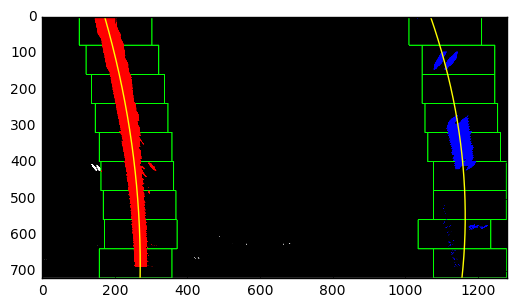

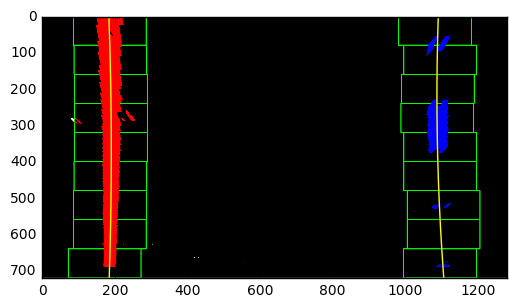

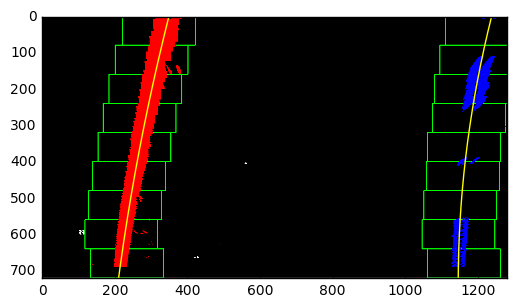

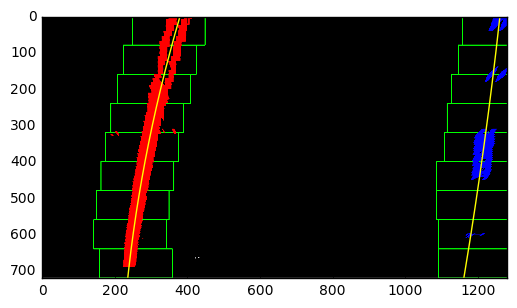

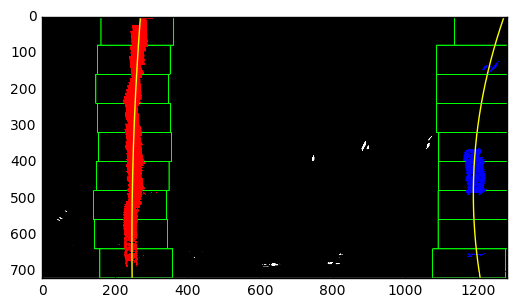

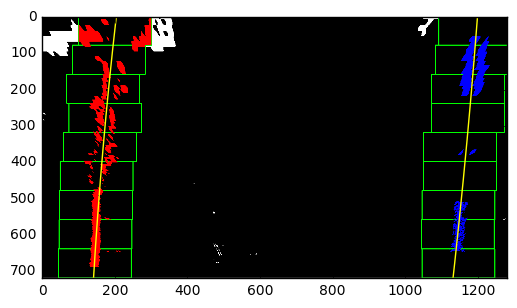

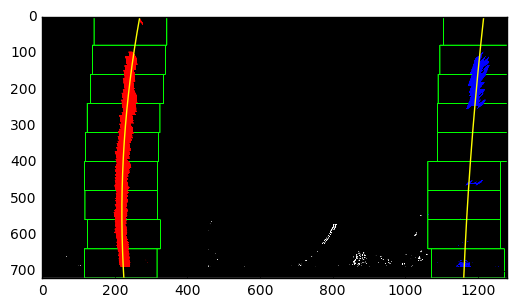

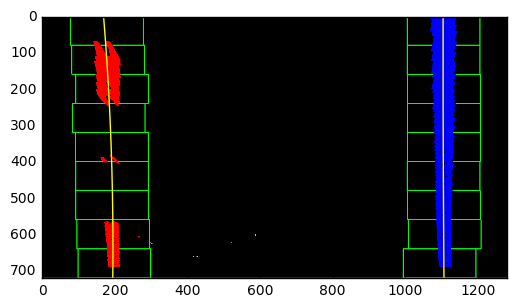

In [26]:
for binary_warped in images:
    histogram = n.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    # Create an output image to draw on and  visualize the result
    out_img = n.dstack((binary_warped, binary_warped, binary_warped))*255
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = n.int(histogram.shape[0]//2)
    leftx_base = n.argmax(histogram[:midpoint])
    rightx_base = n.argmax(histogram[midpoint:]) + midpoint

    # Choose the number of sliding windows
    nwindows = 9
    # Set height of windows
    window_height = n.int(binary_warped.shape[0]//nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = n.array(nonzero[0])
    nonzerox = n.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),
        (0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),
        (0,255,0), 2) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = n.int(n.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = n.int(n.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = n.concatenate(left_lane_inds)
    right_lane_inds = n.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    # Fit a second order polynomial to each
    left_fit = n.polyfit(lefty, leftx, 2)
    right_fit = n.polyfit(righty, rightx, 2)
    
    # Generate x and y values for plotting
    ploty = n.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
    plt.figure()
    plt.imshow(out_img)
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')
    plt.xlim(0, 1280)
    plt.ylim(720, 0)
    
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension

    # Fit new polynomials to x,y in world space
    left_fit_cr = n.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = n.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)
    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / n.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / n.absolute(2*right_fit_cr[0])
    # Now our radius of curvature is in meters
    print(left_curverad, 'm', right_curverad, 'm')
    # Example values: 632.1 m    626.2 m


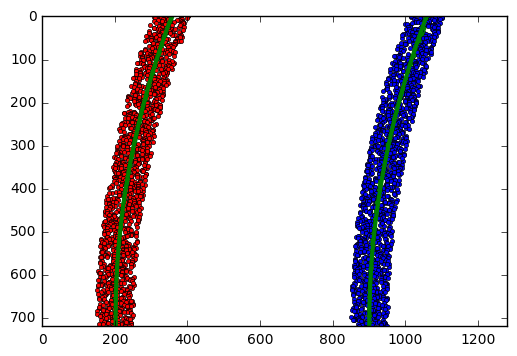

In [2]:
import numpy as np
import matplotlib.pyplot as plt
# Generate some fake data to represent lane-line pixels
ploty = n.linspace(0, 719, num=720)# to cover same y-range as image
quadratic_coeff = 3e-4 # arbitrary quadratic coefficient
# For each y position generate random x position within +/-50 pix
# of the line base position in each case (x=200 for left, and x=900 for right)
leftx = n.array([200 + (y**2)*quadratic_coeff + n.random.randint(-50, high=51) 
                              for y in ploty])
rightx = n.array([900 + (y**2)*quadratic_coeff + n.random.randint(-50, high=51) 
                                for y in ploty])

leftx = leftx[::-1]  # Reverse to match top-to-bottom in y
rightx = rightx[::-1]  # Reverse to match top-to-bottom in y


# Fit a second order polynomial to pixel positions in each fake lane line
left_fit = n.polyfit(ploty, leftx, 2)
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fit = n.polyfit(ploty, rightx, 2)
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

# Plot up the fake data
mark_size = 3
plt.plot(leftx, ploty, 'o', color='red', markersize=mark_size)
plt.plot(rightx, ploty, 'o', color='blue', markersize=mark_size)
plt.xlim(0, 1280)
plt.ylim(0, 720)
plt.plot(left_fitx, ploty, color='green', linewidth=3)
plt.plot(right_fitx, ploty, color='green', linewidth=3)
plt.gca().invert_yaxis() # to visualize as we do the images
plt.show()

In [20]:
# Define y-value where we want radius of curvature
# I'll choose the maximum y-value, corresponding to the bottom of the image
y_eval = n.max(ploty)
left_curverad = ((1 + (2*left_fit[0]*y_eval + left_fit[1])**2)**1.5) / n.absolute(2*left_fit[0])
right_curverad = ((1 + (2*right_fit[0]*y_eval + right_fit[1])**2)**1.5) / n.absolute(2*right_fit[0])
print(left_curverad, right_curverad)
# Example values: 1926.74 1908.48

719.0
7829.41460576 76224.9881115


In [21]:
# Define conversions in x and y from pixels space to meters
ym_per_pix = 30/720 # meters per pixel in y dimension
xm_per_pix = 3.7/700 # meters per pixel in x dimension

# Fit new polynomials to x,y in world space
left_fit_cr = n.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
right_fit_cr = n.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)
# Calculate the new radii of curvature
left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / n.absolute(2*left_fit_cr[0])
right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / n.absolute(2*right_fit_cr[0])
# Now our radius of curvature is in meters
print(left_curverad, 'm', right_curverad, 'm')
# Example values: 632.1 m    626.2 m

2571.15035442 m 25033.9750758 m


## Full pipeline

804.833063248 m 533.739785291 m
3565.39791799 m 2245.82119567 m
2128.22577505 m 991.606426726 m
1304.2296776 m 9664.44061414 m
2762.25419808 m 469.441035731 m
2273.70219981 m 2833.44946213 m
994.515971769 m 3303.1386973 m
2654.79797579 m 24463.6824446 m


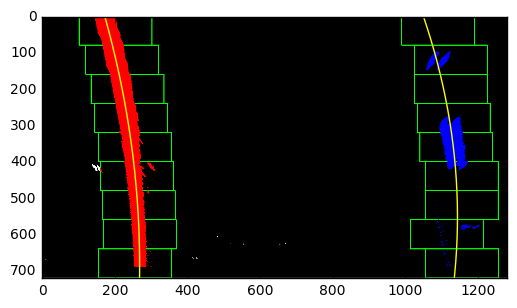

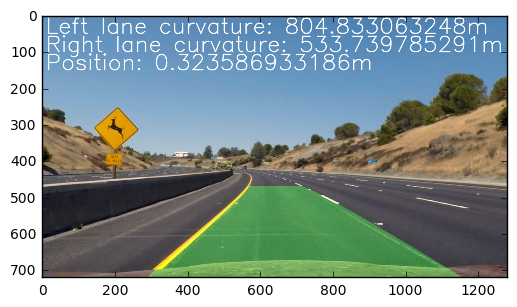

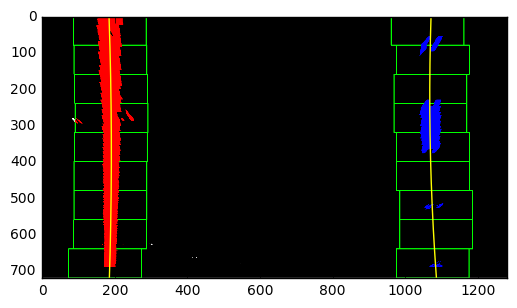

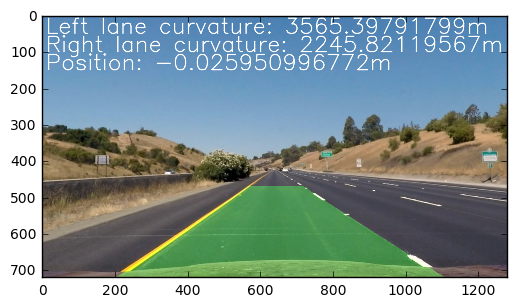

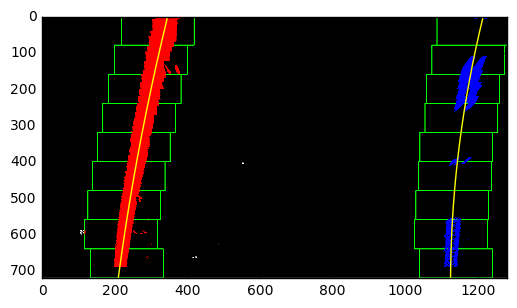

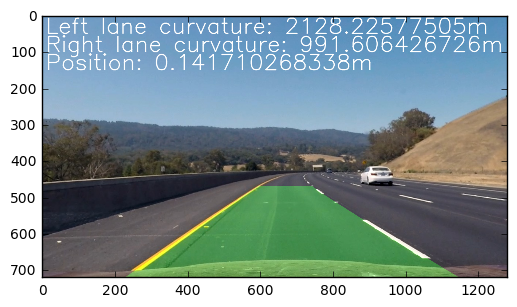

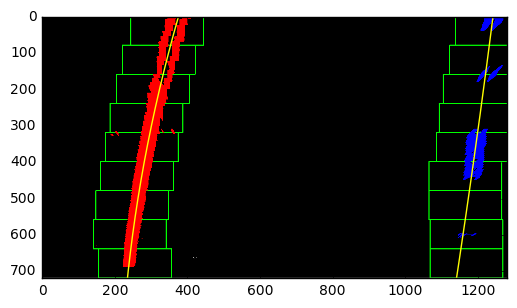

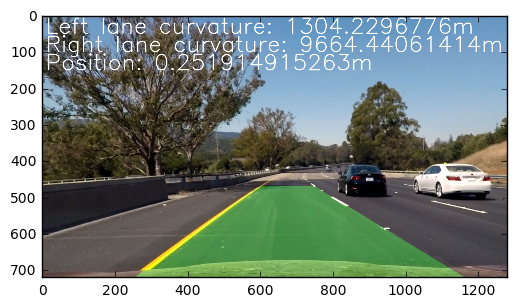

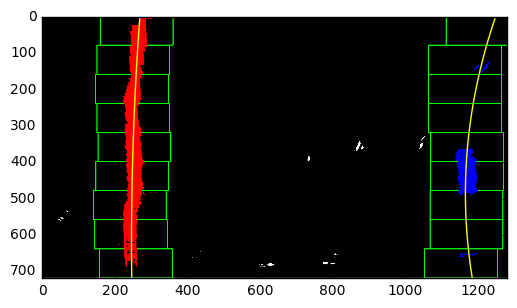

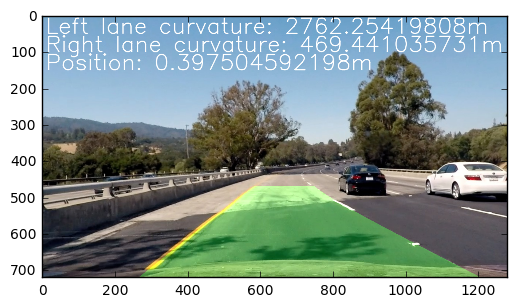

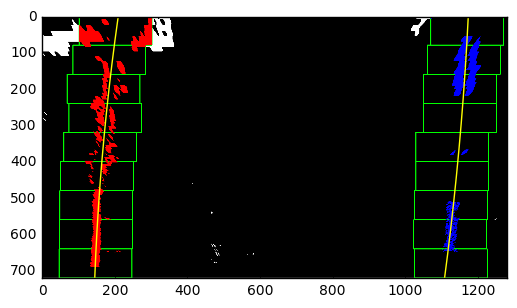

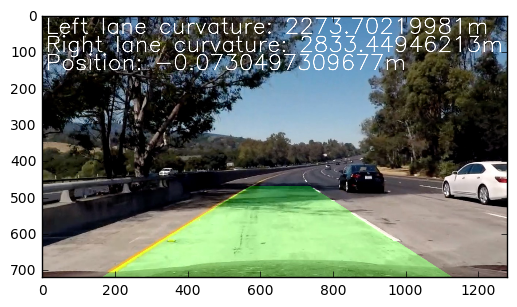

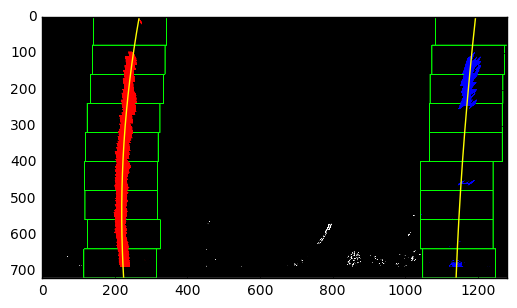

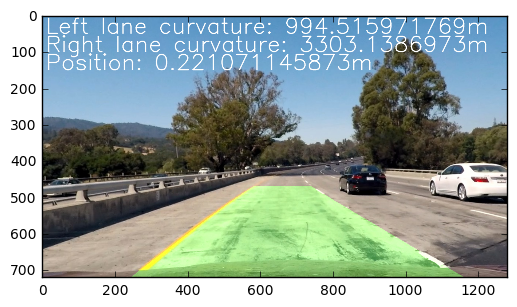

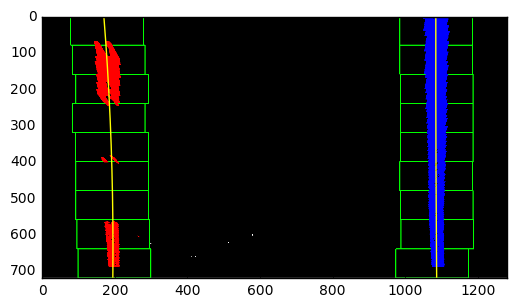

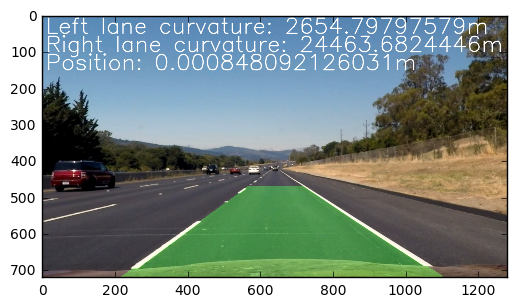

In [49]:
# camera calibration
cam_cali_dir = 'camera_cal/'
objpoints, imgpoints = calibrate_camera(cam_cali_dir, num_corners=(9,6))
do_plot = False

# pipeline starts
for fname in os.listdir('test_images/'):
    # read in image
    image = mpimg.imread(opj('test_images/', fname))
    
    # correct for distortion
    undist_image = cal_undistort(image, objpoints=objpoints, imgpoints=imgpoints)
    
    # apply gradient and color threshold
    grad_image = grad_threshold(undist_image, do_plot=do_plot)
    h, w = grad_image.shape[:2]
    h_offset = 50

    # get ROI
    lower_left = (100, h - h_offset)
    upper_left = (550, 420)
    upper_right = (666, 420)
    lower_right = (1200, h - h_offset)
    vertices = n.array([[lower_left, upper_left, upper_right, lower_right]], dtype=n.int32)

    # crop ROI
    masked_grad_image = crop_roi(grad_image, vertices, do_plot=do_plot)
    
    # apply perspective transform
    src = n.array([[220, 720], [570, 470], [720, 470], [1100, 720]], dtype=n.float32)
    dst = n.array([[200,720], [200,0], [1080,0], [1080,720]], dtype=n.float32)
    binary_warped, M, Minv = apply_perspective_transform(masked_grad_image, src, dst, do_plot=do_plot)
    
    # find lines and fit second order polynomial
    histogram = n.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    # Create an output image to draw on and  visualize the result
    out_img = n.dstack((binary_warped, binary_warped, binary_warped))*255
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = n.int(histogram.shape[0]//2)
    leftx_base = n.argmax(histogram[:midpoint])
    rightx_base = n.argmax(histogram[midpoint:]) + midpoint

    # Choose the number of sliding windows
    nwindows = 9
    # Set height of windows
    window_height = n.int(binary_warped.shape[0]//nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = n.array(nonzero[0])
    nonzerox = n.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),
        (0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),
        (0,255,0), 2) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = n.int(n.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = n.int(n.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = n.concatenate(left_lane_inds)
    right_lane_inds = n.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    # Fit a second order polynomial to each
    left_fit = n.polyfit(lefty, leftx, 2)
    right_fit = n.polyfit(righty, rightx, 2)
    
    # Generate x and y values for plotting
    ploty = n.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
    plt.figure()
    plt.imshow(out_img)
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')
    plt.xlim(0, 1280)
    plt.ylim(720, 0)
    
    offset = ((left_fitx[-1] + right_fitx[-1]) * 0.5 - midpoint) * xm_per_pix
    
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension

    # Fit new polynomials to x,y in world space
    left_fit_cr = n.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = n.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)
    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / n.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / n.absolute(2*right_fit_cr[0])
    # Now our radius of curvature is in meters
    print(left_curverad, 'm', right_curverad, 'm')
    # Example values: 632.1 m    626.2 m

    # Create an image to draw the lines on
    warp_zero = n.zeros_like(binary_warped).astype(n.uint8)
    color_warp = n.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = n.array([n.transpose(n.vstack([left_fitx, ploty]))])
    pts_right = n.array([n.flipud(n.transpose(n.vstack([right_fitx, ploty])))])
    pts = n.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, n.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (image.shape[1], image.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(undist_image, 1, newwarp, 0.3, 0)
    font = cv2.FONT_HERSHEY_SIMPLEX
    cv2.putText(result,'Left lane curvature: ' + str(left_curverad) + 'm',(10,50), font, 2,(255,255,255),2,cv2.LINE_AA)
    cv2.putText(result,'Right lane curvature: ' + str(right_curverad) + 'm',(10,100), font, 2,(255,255,255),2,cv2.LINE_AA)
    cv2.putText(result,'Position: ' + str(offset) + 'm',(10,150), font, 2,(255,255,255),2,cv2.LINE_AA)
    plt.figure()
    plt.imshow(result)

In [63]:
## Write for video
# camera calibration
cam_cali_dir = 'camera_cal/'
objpoints, imgpoints = calibrate_camera(cam_cali_dir, num_corners=(9,6))
do_plot = False

def process_image(image):

    # correct for distortion
    undist_image = cal_undistort(image, objpoints=objpoints, imgpoints=imgpoints)

    # apply gradient and color threshold
    grad_image = grad_threshold(undist_image, do_plot=do_plot)
    h, w = grad_image.shape[:2]
    h_offset = 50

    # crop ROI
    masked_grad_image = crop_roi(grad_image, vertices, do_plot=do_plot)

    # apply perspective transform
    src = n.array([[220, 720], [570, 470], [720, 470], [1100, 720]], dtype=n.float32)
    dst = n.array([[200,720], [200,0], [1080,0], [1080,720]], dtype=n.float32)
    binary_warped, M, Minv = apply_perspective_transform(masked_grad_image, src, dst, do_plot=do_plot)

    # find lines and fit second order polynomial
    histogram = n.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    # Create an output image to draw on and  visualize the result
    out_img = n.dstack((binary_warped, binary_warped, binary_warped))*255
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = n.int(histogram.shape[0]//2)
    leftx_base = n.argmax(histogram[:midpoint])
    rightx_base = n.argmax(histogram[midpoint:]) + midpoint

    # Choose the number of sliding windows
    nwindows = 9
    # Set height of windows
    window_height = n.int(binary_warped.shape[0]//nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = n.array(nonzero[0])
    nonzerox = n.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),
        (0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),
        (0,255,0), 2) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = n.int(n.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = n.int(n.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = n.concatenate(left_lane_inds)
    right_lane_inds = n.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    # Fit a second order polynomial to each
    left_fit = n.polyfit(lefty, leftx, 2)
    right_fit = n.polyfit(righty, rightx, 2)

    # Generate x and y values for plotting
    ploty = n.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
#     plt.figure()
#     plt.imshow(out_img)
#     plt.plot(left_fitx, ploty, color='yellow')
#     plt.plot(right_fitx, ploty, color='yellow')
#     plt.xlim(0, 1280)
#     plt.ylim(720, 0)

    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension

    offset = ((left_fitx[-1] + right_fitx[-1]) * 0.5 - midpoint) * xm_per_pix

    # Fit new polynomials to x,y in world space
    left_fit_cr = n.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = n.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)
    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / n.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / n.absolute(2*right_fit_cr[0])
    # Now our radius of curvature is in meters
    print(left_curverad, 'm', right_curverad, 'm')
    # Example values: 632.1 m    626.2 m

    # Create an image to draw the lines on
    warp_zero = n.zeros_like(binary_warped).astype(n.uint8)
    color_warp = n.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = n.array([n.transpose(n.vstack([left_fitx, ploty]))])
    pts_right = n.array([n.flipud(n.transpose(n.vstack([right_fitx, ploty])))])
    pts = n.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, n.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (image.shape[1], image.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(undist_image, 1, newwarp, 0.3, 0)
    font = cv2.FONT_HERSHEY_SIMPLEX
    cv2.putText(result,'Left lane curvature: ' + str(left_curverad) + 'm',(10,50), font, 2,(255,255,255),2,cv2.LINE_AA)
    cv2.putText(result,'Right lane curvature: ' + str(right_curverad) + 'm',(10,100), font, 2,(255,255,255),2,cv2.LINE_AA)
    cv2.putText(result,'Position: ' + str(offset) + 'm',(10,150), font, 2,(255,255,255),2,cv2.LINE_AA)
    return result
#     plt.figure()
#     plt.imshow(result)

In [1]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

yellow_output = 'project_video_result.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4').subclip(0,5)
clip2 = VideoFileClip('project_video.mp4')
yellow_clip = clip2.fl_image(process_image)
%time yellow_clip.write_videofile(yellow_output, audio=False)